In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nengo
import sspspace
import time
from uniform_encoders import *
palette = sns.color_palette("dark")
sns.set_palette(palette)
sns.set(context='paper', style='white')

# Store state SSP in an integrator during the presentation phase, recall it during the feedback phase

In [27]:
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

P = 2  # trial time
pt = 1  # presentation time
ft = P-pt  # feedback time
T = 5*P  # total time

ssp_dim = 64  # SSP dimension
length_scale = 10  # lengthscale hypeparameter
state_neurons = 3000
memory_neurons = 3000
state_intercept = 0.0
memory_intercept = -0.3

# Initialize SSP space
ssp_space = sspspace.RandomSSPSpace(ssp_dim=ssp_dim, domain_dim=3, rng=rng)
ssp_space.update_lengthscale([length_scale, length_scale, length_scale])

# dynamic input to the network
objects = []
for trial in range(int(T/P)):
    features = rng.uniform(-1,1,size=3)
    object_ssp = ssp_space.encode(features)
    objects.append(object_ssp)

# dynamic input to the network
input_func = lambda t: objects[int(t/P)].flatten()  #  if t%P<pt else np.zeros((ssp_dim))
stop_func = lambda t: 0 if t%P<pt else -1000

# encoders and intercepts determine tuning curve distribution
state_encoders = ScatteredHypersphere(surface=True).sample(state_neurons, ssp_dim, rng=rng)
state_intercepts = nengo.dists.Uniform(state_intercept, state_intercept)
memory_encoders = ScatteredHypersphere(surface=True).sample(memory_neurons, ssp_dim, rng=rng)
memory_intercepts = nengo.dists.Uniform(memory_intercept, memory_intercept)

# nengo Network
network = nengo.Network(seed=seed)
with network:
    inpt_ssp = nengo.Node(input_func)
    stop = nengo.Node(stop_func)
    state = nengo.Ensemble(n_neurons=state_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=state_encoders, intercepts=state_intercepts)
    diff = nengo.Ensemble(n_neurons=state_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=state_encoders, intercepts=state_intercepts)
    memory = nengo.Ensemble(n_neurons=memory_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=memory_encoders, intercepts=memory_intercepts)
    state2 = nengo.Ensemble(n_neurons=state_neurons, dimensions=ssp_dim, seed=seed,
                            encoders=state_encoders, intercepts=state_intercepts)
    
    nengo.Connection(inpt_ssp, state, synapse=None)
    nengo.Connection(state, diff, synapse=0.01)
    nengo.Connection(diff, memory, synapse=0.1)
    nengo.Connection(memory, diff, synapse=0.01, transform=-1)
    nengo.Connection(memory, memory, synapse=0.1)
    nengo.Connection(memory, state2, synapse=0.01)
    nengo.Connection(stop, state.neurons, synapse=None, transform=np.ones((state_neurons, 1)))
    nengo.Connection(stop, diff.neurons, synapse=None, transform=np.ones((memory_neurons, 1)))
    
    p_ssp = nengo.Probe(inpt_ssp, synapse=0.01)
    p_state = nengo.Probe(state, synapse=0.01)
    p_state2 = nengo.Probe(state2, synapse=0.01)
    p_diff = nengo.Probe(diff, synapse=0.01)
    p_memory = nengo.Probe(memory, synapse=0.01)

sim = nengo.Simulator(network, progress_bar=False)
with sim:
    sim.run(T-0.001)

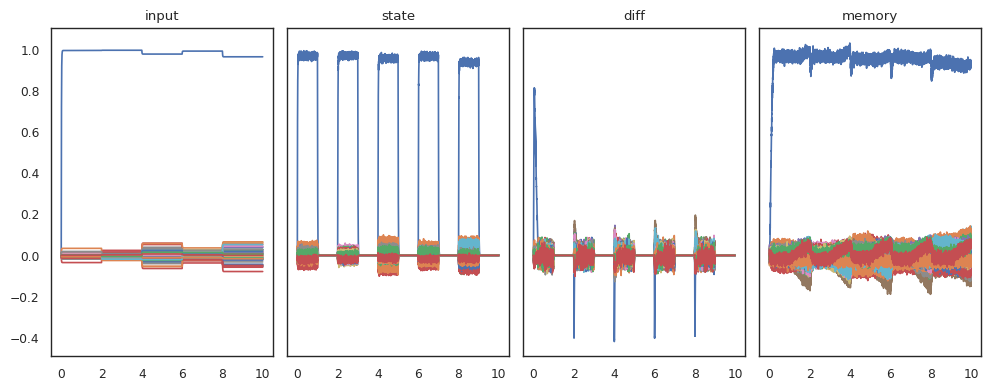

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(10,4))
axes[0].plot(sim.trange(), sim.data[p_ssp])
axes[1].plot(sim.trange(), sim.data[p_state])
axes[2].plot(sim.trange(), sim.data[p_diff])
axes[3].plot(sim.trange(), sim.data[p_memory])
axes[0].set(title='input')
axes[1].set(title='state')
axes[2].set(title='diff')
axes[3].set(title='memory')
plt.tight_layout()

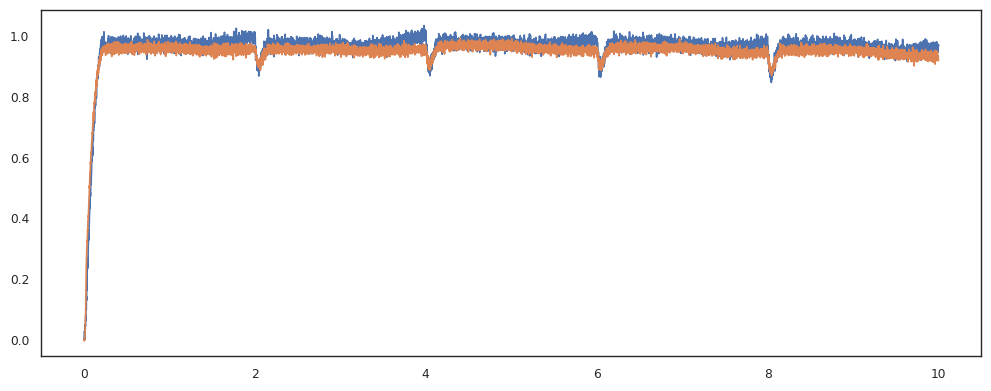

In [29]:
ssp_memory_similarity = np.sum(sim.data[p_memory] * sim.data[p_ssp], axis=1, keepdims=True)
state2_memory_similarity = np.sum(sim.data[p_state2] * sim.data[p_ssp], axis=1, keepdims=True)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
axes.plot(sim.trange(), ssp_memory_similarity)
axes.plot(sim.trange(), state2_memory_similarity)
plt.tight_layout()